In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

sns.set_theme()

#### Reading csv file

In [25]:
df = pd.read_csv("loanprediction.csv", index_col = 0)
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252000 entries, 1 to 252000
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 25.0+ MB


#### Renaming columns

In [10]:
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]
df.head()

#### Drop column(s)

In [29]:
# df.drop("state", axis=1)
# df.drop("city", axis=1)

#### Encoding categorical variables

In [11]:
en = LabelEncoder()
cat_cols = ["marital_status", "house_ownership", "car_ownership", "profession", "city", "state"]
for cols in cat_cols:
    df[cols] = en.fit_transform(df[cols])
    
df.head()

,income,age,experience,marital_status,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
Id,,,,,,,,,,,,
1,1303834,23,3,1,2,0,33,251,13,3,13,0
2,7574516,40,10,1,2,0,43,227,14,9,13,0
3,3991815,66,4,0,2,0,47,8,12,4,10,0
4,6256451,41,2,1,2,1,43,54,17,2,12,1
5,5768871,47,11,1,2,0,11,296,22,3,14,1


In [12]:
y = df["risk_flag"]
x = df.drop("risk_flag", axis=1)

#### Splitting the dataset to train and test sets

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2021)

#### Perform oversampling on train data

<AxesSubplot:xlabel='risk_flag', ylabel='count'>

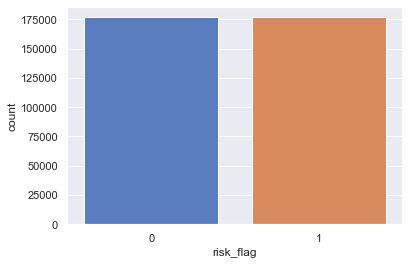

In [34]:
oversampler = SMOTE()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

sns.countplot(x = y_train, palette = 'muted')

In [39]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    use_label_encoder=False,
                    random_state=2021)

xgb.fit(x_train, y_train, eval_metric='logloss')
y_pred = xgb.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

In [38]:
print("-------------------------TEST SCORES-----------------------")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred)}")

-------------------------TEST SCORES-----------------------
Recall: 0.9465199474709052
Precision: 0.9013756522489111
F1-Score: 0.92339635978088
Accuracy score: 0.9215402366462297
AUC Score: 0.9215600008626794


Configurations
1. No columns dropped
2. Upsampling done on train set
3. xgboost parameters: learning_rate=0.1, n_estimators=1000